In [2]:
import pandas as pd

In [3]:
class UnionFind:
    def __init__(self):
        self.parent = {}
        self.size = {}

    def find(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.size[x] = 1
        if self.parent[x] == x:
            return x
        else:
            self.parent[x] = self.find(self.parent[x])
            return self.parent[x]

    def same(self, x, y):
        return self.find(x) == self.find(y)

    def get_size(self, x):
        return self.size[self.find(x)]

    def unite(self, x, y):
        x = self.find(x)
        y = self.find(y)
        if x != y:
            self.parent[x] = y
            self.size[y] += self.size[x]
            self.size[x] = 0


In [4]:
df_train = pd.read_csv('../data/input/train.csv')
df_test = pd.read_csv('../data/input/test.csv')

In [5]:
uf = UnionFind()

In [6]:
from tqdm import tqdm
for i, (q1, q2) in tqdm(enumerate(zip(df_train.question1.astype(str), df_train.question2.astype(str)))):
    uf.unite(q1, q2)

404290it [00:01, 240254.38it/s]


In [7]:
for i, (q1, q2) in tqdm(enumerate(zip(df_test.question1.astype(str), df_test.question2.astype(str)))):
    uf.unite(q1, q2)

2345796it [00:09, 255066.49it/s]


In [8]:
not_isolated_train = []
for i, (q1, q2) in tqdm(enumerate(zip(df_train.question1.astype(str), df_train.question2.astype(str)))):
    not_isolated_train.append(1 if uf.get_size(q1) > 2 else 0)

404290it [00:01, 341548.22it/s]


In [9]:
not_isolated_test = []
for i, (q1, q2) in tqdm(enumerate(zip(df_test.question1.astype(str), df_test.question2.astype(str)))):
    not_isolated_test.append(1 if uf.get_size(q1) > 2 else 0)

2345796it [00:07, 324386.08it/s]


In [10]:
df_train['not_isolated'] = not_isolated_train
df_test['not_isolated'] = not_isolated_test

In [11]:
df_train.not_isolated.mean()

0.70796952682480396

In [12]:
df_test.not_isolated.mean()

0.17570538955646611

In [13]:
df_train_not_isolated = df_train[df_train.not_isolated == 1]

In [14]:
df_test_not_isolated = df_test[df_test.not_isolated == 1]

In [15]:
from collections import defaultdict
connected_components = defaultdict(list)

In [16]:
for i, (q1, q2, d) in tqdm(enumerate(zip(df_train_not_isolated.question1.astype(str), df_train_not_isolated.question2.astype(str), df_train_not_isolated.is_duplicate))):
    connected_components[uf.find(q1)].append((q1, q2, d))

286225it [00:01, 244598.71it/s]


In [17]:
for i, (q1, q2) in tqdm(enumerate(zip(df_test_not_isolated.question1.astype(str), df_test_not_isolated.question2.astype(str)))):
    connected_components[uf.find(q1)].append((q1, q2, -1))

412169it [00:01, 257208.07it/s]


In [18]:
connected_components[uf.find(q1)]

[('What should I do for changing myself?',
  "How do I change myself from a guy that doesn't like Indonesia into a guy that loves Indonesia?",
  0),
 ('How can I change myself completely?',
  'What are some good investment tips for a newlywed couple?',
  0),
 ('How can I change myself?',
  "How do I change myself from a guy that doesn't like Indonesia into a guy that loves Indonesia?",
  0),
 ('How can I change myself completely?',
  "How do I change myself from a guy that doesn't like Indonesia into a guy that loves Indonesia?",
  0),
 ('How can I change myself?',
  'Is being average a sin? I want to change myself. What should I do?',
  -1),
 ('Can I change myself?', 'How can I change myself?', -1)]

In [19]:
print(len((connected_components.values())))

122064


In [20]:
cc_with_train = {}
for k, cc in connected_components.items():
    if max([val for (q1, q2, val) in cc]) >= 0:
        cc_with_train[k] = cc

In [21]:
print(len(cc_with_train))

60890


In [72]:
def connected_component_stats(connected_components, uf):
    cc_sizes = []
    cc_edge_sizes = []
    cc_labels = []
    cc_num_train_edges = []
    cc_duplicate_ratios = []
    for k, cc in connected_components.items():
        cc_edge_sizes.append(len(cc))
        cc_sizes.append(uf.get_size(k))
        cc_labels.append(k)
        duplicate = 0
        total = 0
        for (a, b, val) in cc:
            if val >= 0:
                if val == 1:
                    duplicate += 1
                total += 1
        cc_num_train_edges.append(total)
        cc_duplicate_ratios.append(float(duplicate) / total if total > 0 else 0)
    temp_df = pd.DataFrame()
    temp_df['node_size'] = cc_sizes
    temp_df['edge_size'] = cc_edge_sizes
    temp_df['label'] = cc_labels
    temp_df['train_edge_count'] = cc_num_train_edges
    temp_df['mean_duplicate'] = cc_duplicate_ratios
    return temp_df

In [22]:
cc_sizes = []
cc_edge_sizes = []
cc_labels = []
cc_num_train_edges = []
cc_duplicate_ratios = []
for k, cc in cc_with_train.items():
    cc_edge_sizes.append(len(cc))
    cc_sizes.append(uf.get_size(k))
    cc_labels.append(k)
    duplicate = 0
    total = 0
    for (a, b, val) in cc:
        if val >= 0:
            if val == 1:
                duplicate += 1
            total += 1
    cc_num_train_edges.append(total)
    cc_duplicate_ratios.append(float(duplicate) / total if total > 0 else 0)


In [23]:
temp_df = pd.DataFrame()
temp_df['node_size'] = cc_sizes
temp_df['edge_size'] = cc_edge_sizes
temp_df['label'] = cc_labels
temp_df['train_edge_count'] = cc_num_train_edges
temp_df['mean_duplicate'] = cc_duplicate_ratios

In [25]:
%matplotlib inline
temp_df[['node_size', 'edge_size', 'mean_duplicate', 'train_edge_count']].describe()

node_size      edge_size  mean_duplicate  train_edge_count
count   60890.000000   60890.000000    60890.000000      60890.000000
mean        7.753720       8.917146        0.250457          4.700690
std       551.200019     857.946581        0.377805        384.799955
min         3.000000       2.000000        0.000000          1.000000
25%         3.000000       2.000000        0.000000          1.000000
50%         4.000000       3.000000        0.000000          2.000000
75%         5.000000       5.000000        0.500000          3.000000
max    136001.000000  211668.000000        1.000000      94925.000000

In [27]:
from IPython.display import display
display(temp_df[temp_df.node_size < 10000].describe())

node_size     edge_size  train_edge_count  mean_duplicate
count  60889.000000  60889.000000      60889.000000    60889.000000
mean       5.520258      5.440999          3.141783        0.250452
std        8.987405     17.386244          9.830580        0.377807
min        3.000000      2.000000          1.000000        0.000000
25%        3.000000      2.000000          1.000000        0.000000
50%        4.000000      3.000000          2.000000        0.000000
75%        5.000000      5.000000          3.000000        0.500000
max      497.000000   2085.000000        638.000000        1.000000

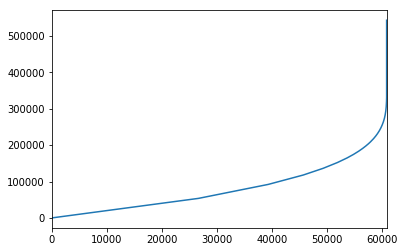

In [28]:
temp_df.sort_values(by='edge_size').reset_index().edge_size.cumsum().plot()

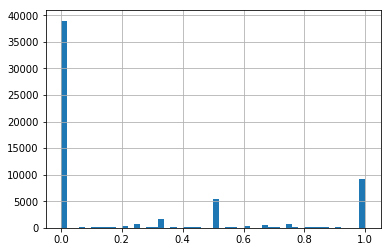

In [29]:
temp_df['mean_duplicate'].hist(bins=50)

In [30]:
temp_df[temp_df.edge_size > 10000]

node_size  edge_size                                   label  \
2763     136001     211668  What is peer to they peer replication?   

      train_edge_count  mean_duplicate  
2763             94925        0.531546

In [31]:
display(temp_df[(temp_df.edge_size == 3) & (temp_df.node_size == 3)])

node_size  edge_size  \
25             3          3   
27             3          3   
59             3          3   
88             3          3   
90             3          3   
117            3          3   
154            3          3   
185            3          3   
211            3          3   
241            3          3   
272            3          3   
277            3          3   
301            3          3   
363            3          3   
398            3          3   
407            3          3   
437            3          3   
460            3          3   
468            3          3   
517            3          3   
544            3          3   
565            3          3   
606            3          3   
622            3          3   
625            3          3   
652            3          3   
670            3          3   
672            3          3   
679            3          3   
736            3          3   
...          ...        ...   
60278          3          3   
60339          3          3   
60341          3          3   
60374          3          3   
60404          3          3   
60427          3          3   
60467          3          3   
60478          3          3   
60485          3          3   
60508          3          3   
60579          3          3   
60599          3          3   
60600          3          3   
60613          3          3   
60663          3          3   
60682          3          3   
60687          3          3   
60692          3          3   
60698          3          3   
60732          3          3   
60733          3          3   
60743          3          3   
60747          3          3   
60781          3          3   
60795          3          3   
60802          3          3   
60805          3          3   
60811          3          3   
60853          3          3   
60879          3          3   

                                                   label  train_edge_count  \
25     What's the difference between in vivo, ex vivo...                 1   
27               Is vacuum energy infinite? How and why?                 3   
59     Is Kim Jong Un the only fat person in North Ko...                 3   
88                    What is the best novel in English?                 3   
90     What do other countries really think about the...                 3   
117    Is it possible to convert India a cashless cou...                 3   
154    Why is McKinsey hiring technical guys (coders)...                 1   
185                  Is being an introvert the new cool?                 3   
211                   What is it like to be an animator?                 3   
241    What is keyword density and what is ideal keyw...                 3   
272                  What do you usually do on weekends?                 3   
277    What is the South Beach Diet? Has it been medi...                 3   
301                         How does paytm earn profits?                 3   
363    Will atheism or agnosticism be ever officially...                 1   
398                     Which guitar tuning is the best?                 3   
407               What is the best way to study for ACT?                 1   
437                                 What is a rectifier?                 3   
460    What are some adaptations of the great white s...                 3   
468          Which was the first social networking site?                 3   
517                Why don't we have a base on the moon?                 3   
544        Why do people say bullies are jealous of you?                 3   
565                How do I choose a topic for blogging?                 1   
606    I am into a habit of over thinking things. How...                 3   
622         What would be a great job for a 16 year old?                 1   
625                        Who are your favorite models?                 2   
652    Is there any connection between gravity and ma...

In [32]:
display(temp_df[(temp_df.edge_size == 3) & (temp_df.node_size == 3) & (temp_df.mean_duplicate < 1)])

node_size  edge_size  \
25             3          3   
154            3          3   
211            3          3   
625            3          3   
1008           3          3   
1108           3          3   
1120           3          3   
1306           3          3   
1560           3          3   
1681           3          3   
2167           3          3   
2250           3          3   
2350           3          3   
2357           3          3   
2522           3          3   
2667           3          3   
2812           3          3   
2941           3          3   
3375           3          3   
3472           3          3   
3655           3          3   
3679           3          3   
3731           3          3   
3747           3          3   
3850           3          3   
3987           3          3   
4029           3          3   
4125           3          3   
4324           3          3   
4489           3          3   
...          ...        ...   
57385          3          3   
57645          3          3   
57683          3          3   
57804          3          3   
57876          3          3   
57910          3          3   
57988          3          3   
58025          3          3   
58140          3          3   
58219          3          3   
58516          3          3   
58533          3          3   
58777          3          3   
58825          3          3   
58969          3          3   
59089          3          3   
59207          3          3   
59320          3          3   
59335          3          3   
59393          3          3   
59790          3          3   
59967          3          3   
60039          3          3   
60166          3          3   
60427          3          3   
60508          3          3   
60600          3          3   
60687          3          3   
60747          3          3   
60811          3          3   

                                                   label  train_edge_count  \
25     What's the difference between in vivo, ex vivo...                 1   
154    Why is McKinsey hiring technical guys (coders)...                 1   
211                   What is it like to be an animator?                 3   
625                        Who are your favorite models?                 2   
1008   How can someone treat grief from the death of ...                 1   
1108                    What do software consultants do?                 1   
1120                              What is a testimonial?                 3   
1306                          How do you deliver a baby?                 2   
1560   Does South Dakota State University plays divis...                 2   
1681   Which sorting algorithm requires the minimum n...                 2   
2167         What are some uses of silicified sandstone?                 3   
2250   What are the disadvantages of external recruit...                 2   
2350                              What is homosexuality?                 3   
2357   What are the courses to do in the USA after th...                 2   
2522                     What checklists do you live by?                 2   
2667           Can I develop an interest in studies now?                 3   
2812               What do I do with a bachelors degree?                 2   
2941                  Why do people reject LGBTQ people?                 3   
3375                       Are non-humans superstitious?                 2   
3472            How did you turn your hobbies into jobs?                 3   
3655   Indonesians who speak Japanese: Where did you ...                 3   
3679                      How do I get admission at ITS?                 2   
3731                       How do I sleep 7 hours a day?                 2   
3747            Where can I buy fresh fish in Bangalore?                 2   
3850   What is your worst experience with an ambulance ?                 2   
3987                     What were the orogenic periods?

In [33]:
display(temp_df[(temp_df.edge_size == 3) & (temp_df.node_size == 3) & (temp_df.mean_duplicate * 3 == 2)])
for i, row in temp_df[(temp_df.edge_size == 3) & (temp_df.node_size == 3) & (temp_df.mean_duplicate * 3 == 2)].iterrows():
    print(connected_components[row['label']])

node_size  edge_size  \
2941           3          3   
48593          3          3   
49046          3          3   
53466          3          3   

                                                   label  train_edge_count  \
2941                  Why do people reject LGBTQ people?                 3   
48593  Can you suggest some PPT topics for mechanical...                 3   
49046        Why natural resources are important for us?                 3   
53466  How does the law of independent assortment com...                 3   

       mean_duplicate  
2941         0.666667  
48593        0.666667  
49046        0.666667  
53466        0.666667

[('Why do black people have such intolerance towards LGBTQ people?', 'Why do people reject LGBTQ people?', 1), ('Why is there hatred towards LGBTQ people?', 'Why do people reject LGBTQ people?', 1), ('Why do black people have such intolerance towards LGBTQ people?', 'Why is there hatred towards LGBTQ people?', 0)]
[('What are the best easy and understandable topics for ppt for mechanical engineering?', 'What are some small, but hot topics for mechanical engineering for PPT?', 0), ('What are the best easy and understandable topics for ppt for mechanical engineering?', 'Can you suggest some PPT topics for mechanical engineer?', 1), ('What are some small, but hot topics for mechanical engineering for PPT?', 'Can you suggest some PPT topics for mechanical engineer?', 1)]
[('Why are natural resources important for us?', 'Why natural resources are important for us?', 0), ('Why are natural resources considered to be important?', 'Why are natural resources important for us?', 1), ('Why are nat

In [34]:
for i, row in temp_df[(temp_df.edge_size == 3) & (temp_df.node_size == 3)].iterrows():
    print(connected_components[row['label']])

[('What are the differences between "in vitro" and "in vivo"?', "What's the difference between in vivo, ex vivo, and in vitro?", 0), ('What is the difference between in vivo and in vitro?', 'What are the differences between "in vitro" and "in vivo"?', -1), ('What is the difference between in vivo and in vitro?', "What's the difference between in vivo, ex vivo, and in vitro?", -1)]
[('Is vacuum energy infinite? If it is, why?', 'Is vacuum energy infinite? How and why?', 1), ('Why is vacuum energy infinite?', 'Is vacuum energy infinite? How and why?', 1), ('Is vacuum energy infinite? If it is, why?', 'Why is vacuum energy infinite?', 1)]
[('Is Kim Jong-un the only fat person in North Korea?', 'Is Kim Jong Un the only fat person in North Korea?', 1), ('North Korea: Is Kim Jong Un the only fat person in North Korea? While everybody is starving..', 'Is Kim Jong-un the only fat person in North Korea?', 1), ('North Korea: Is Kim Jong Un the only fat person in North Korea? While everybody is s

In [35]:
print(temp_df.edge_size[(temp_df.node_size > 10)].sum())
print(temp_df.edge_size[(temp_df.node_size > 0)].sum())

348692
542965


In [36]:
pd.options.display.max_colwidth = 100
temp_df[(temp_df.node_size > 10)]

node_size  edge_size  \
4             12         13   
6             11         11   
10            52         53   
16            20         22   
30            17         17   
34            15         18   
44            23         23   
46            11         10   
62            16         18   
70            16         15   
75            31         32   
89            11         10   
91            13         12   
111           67         91   
118           17         16   
151           16         37   
164           32         34   
181           11         21   
195           11         16   
217           24         28   
227           13         12   
230           14         29   
247           14         14   
285           25         35   
299           13         12   
317           11         12   
330           13         15   
332           11         12   
343          228        339   
379           12         11   
...          ...        ...   
60487         11         11   
60494         11         31   
60502         21         23   
60503         14         19   
60512         13         26   
60514         12         13   
60519         35        119   
60540         15         18   
60553         14         13   
60555         19         19   
60574         17         20   
60595         12         12   
60626         14         16   
60631         21         23   
60638         13         12   
60644         13         15   
60655         14         14   
60667         19         26   
60702         33         42   
60703         11         11   
60704         17         17   
60731         11         10   
60744         19         21   
60752         19         19   
60773         19         19   
60793         34         56   
60835         12         11   
60863         12         13   
60875         11         11   
60883         19         20   

                                                                                                     label  \
4                                                 What is the meaning of the Blind Lady of Justice statue?   
6                                   Why do people have so much pride about being an INTJ personality type?   
10                                                                  Is it legal to share Netflix accounts?   
16                                                                            Why am I afraid of my death?   
30                                            How do you determine how many valence electrons are in iron?   
34                                                               How does income tax on mutual funds work?   
44                                                                      How much is Sterling Silver worth?   
46                                                Where can I get traditional painting services in Sydney?   
62                                                      How do I convert an array into single linked list?   
70           What percentage of Muslims would secretly like to leave Islam but are too terrified to do so?   
75                                                                       What's in an MIT admissions tube?   
89                                                             What clothes do Indian women normally wear?   
91                                                                                How do I purchase using?   
111                      How do I get guys at my high school to like me and ask me out, without faking it?   
118    [SPOILER ALERT] How is it possible that in the story Itachi told to Sasuke, Uchihas were doing I...   
151                                     What is the websites that I must visit everyday to gain knowledge?   
164                                                How does it feel to have a fight with your best friend?   
181                                                                                     What is error 40

In [60]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(question, connected_components):
    g = nx.Graph()
    edge_labels = {}
    for (q1, q2, value) in connected_components[question]:
        g.add_edge(q1, q2, color="red" if value == 1 else "blue" if value == 0 else "black")
    plt.figure(figsize=(15, 8))
    plt.axis('off')
    colors = [g[u][v]['color'] for u,v in g.edges()]
    pos=nx.spring_layout(g)
    nx.draw_networkx(g, edge_color=colors, width=2, pos=pos)

What is the meaning of the Blind Lady of Justice statue?
Why do people have so much pride about being an INTJ personality type?
Is it legal to share Netflix accounts?
Why am I afraid of my death?
How do you determine how many valence electrons are in iron?
How does income tax on mutual funds work?
How much is Sterling Silver worth?
Where can I get traditional painting services in Sydney?
How do I convert an array into single linked list?
What percentage of Muslims would secretly like to leave Islam but are too terrified to do so?
What's in an MIT admissions tube?
What clothes do Indian women normally wear?
How do I purchase using?
How do I get guys at my high school to like me and ask me out, without faking it?
[SPOILER ALERT] How is it possible that in the story Itachi told to Sasuke, Uchihas were doing Izanagi?
What is the websites that I must visit everyday to gain knowledge?
How does it feel to have a fight with your best friend?
What is error 404?
When is the FBI going to announce

/Users/takanori/Study/machine-learning/Kaggle/QuoraQuestionPairs/venv/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Is there a Drug and Alcohol Rehab Center in Nome County AK?
How can we communicate with animals?
Where does the word "atheist" come from?
What do Americans think of British money?
What are some ways to permanently deal with bullies. And what are some really good ways to embarrass them publicly?
How do you play BluRay discs on an Xbox 360?
How important is it for fighter jet pilots to see inbound hostile missiles?
What is the Lewis Dot structure for Br3?
Do you get paid while doing a PhD in Canada?
How is living in the San Francisco area?
What are the models we use to calculate earth's temperature throughout its history?
Can a director of a private limited company in India gift his property to the company?
What does web application refer to?
How does "Shaman King's" manga compare to the anime series? Which one is more popular and why?
How do you give Benadryl to a dog?
You user on Quora?
How has North Korea changed under Kim Jong-un?
What learn zombo.com?
What should I do if I fall in l

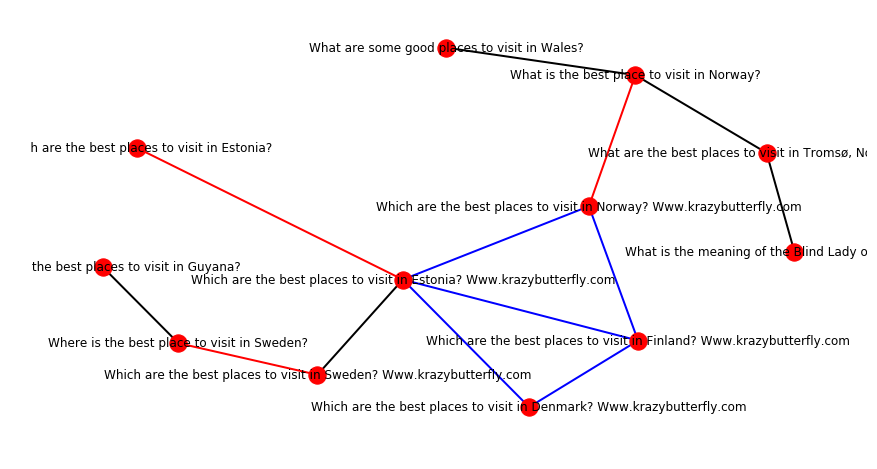

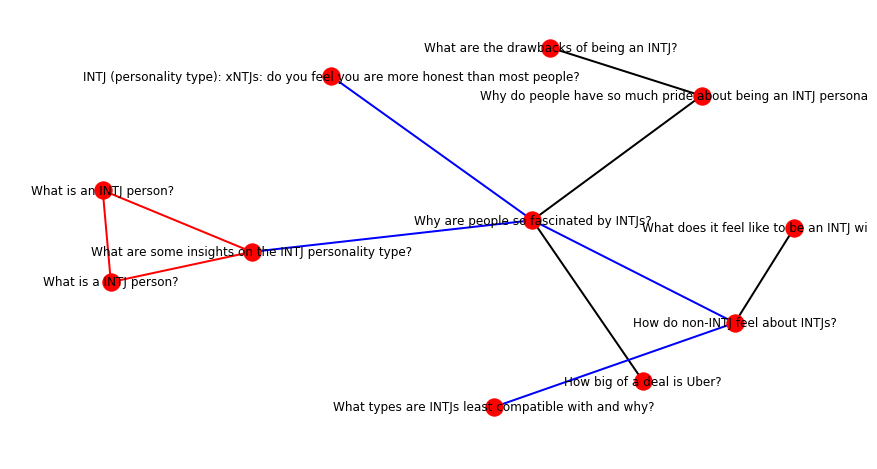

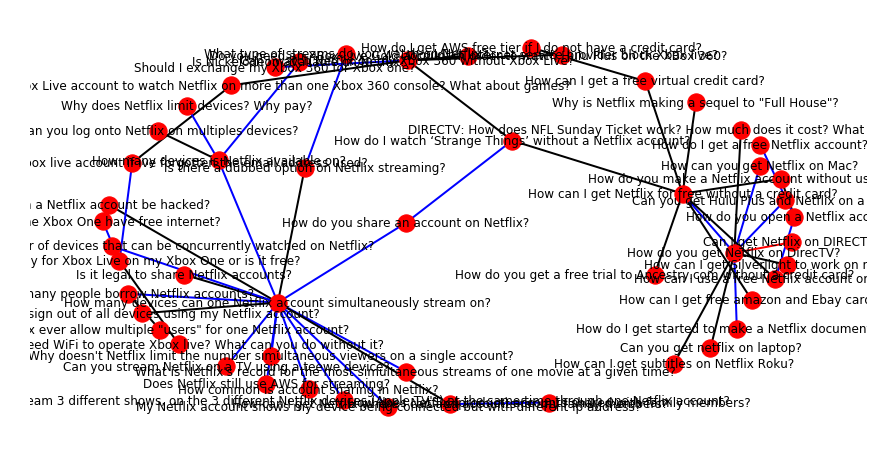

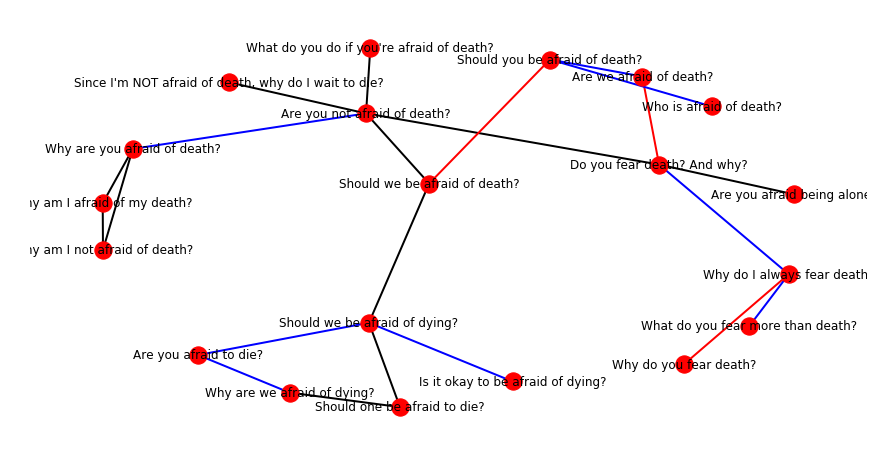

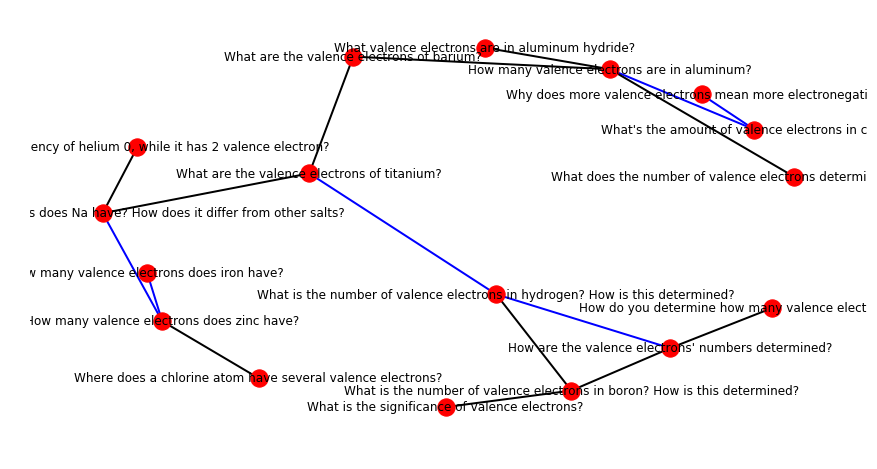

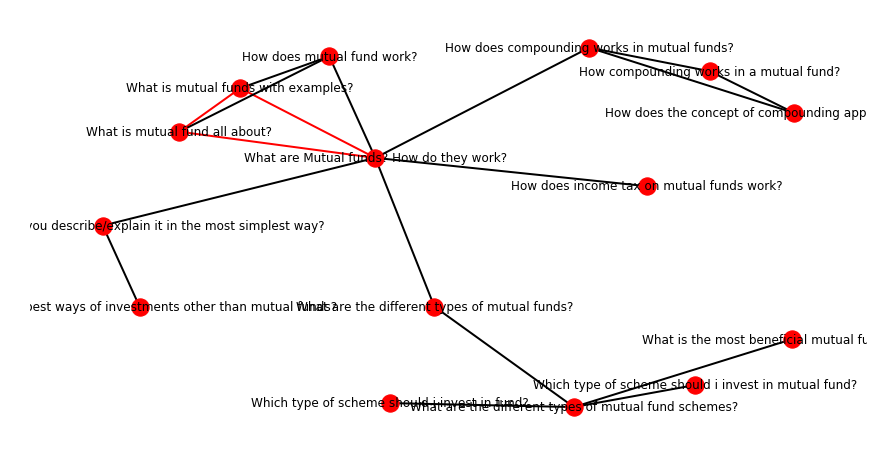

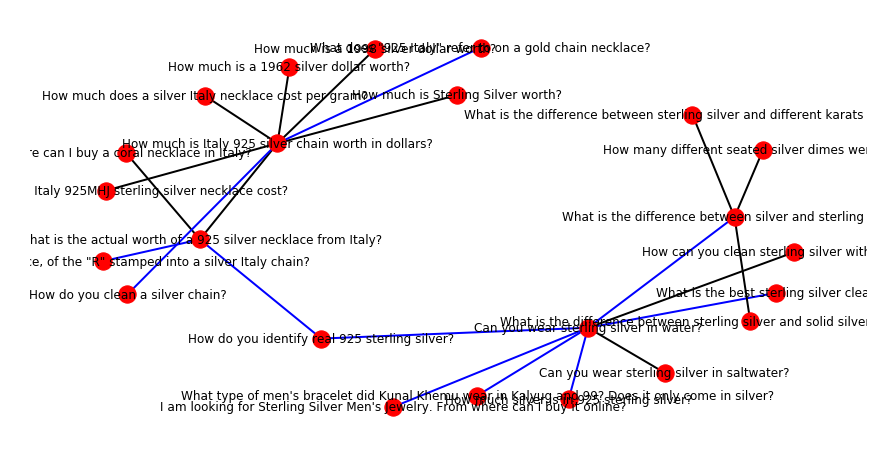

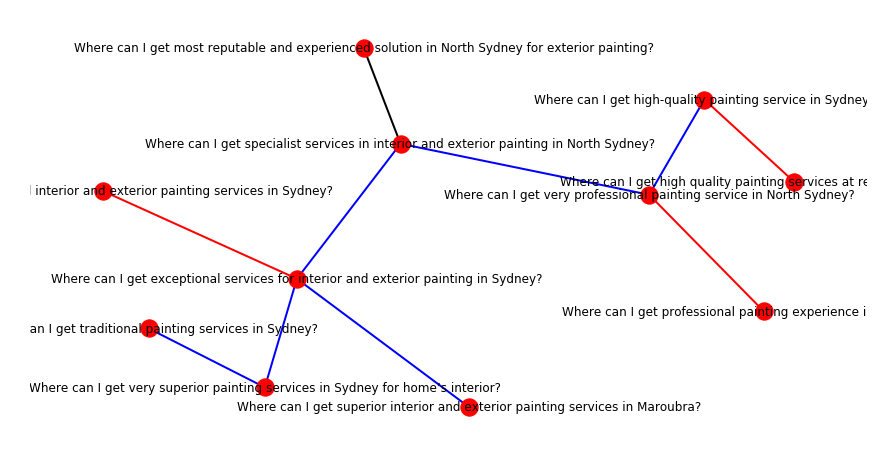

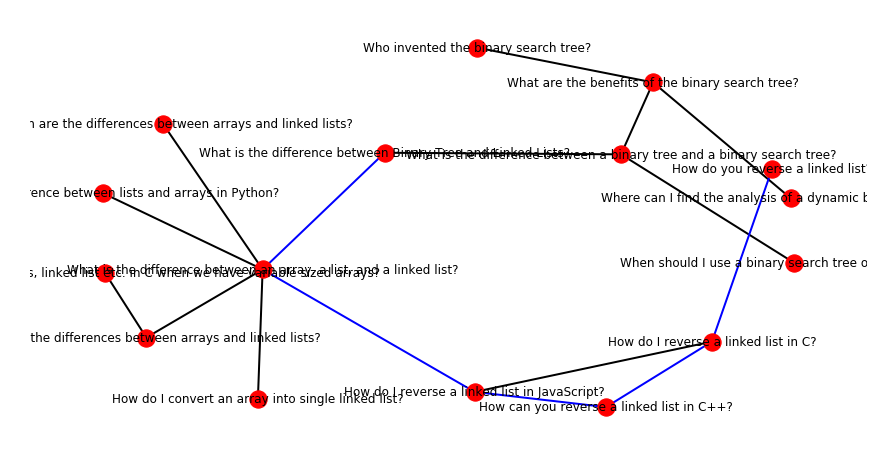

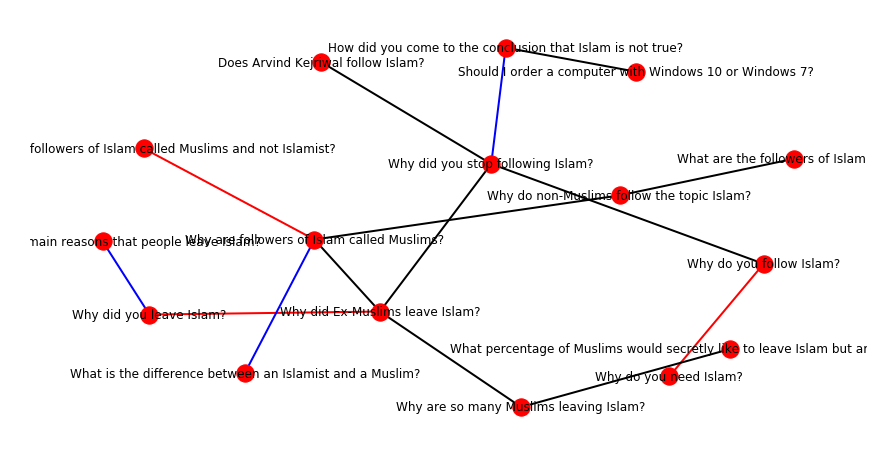

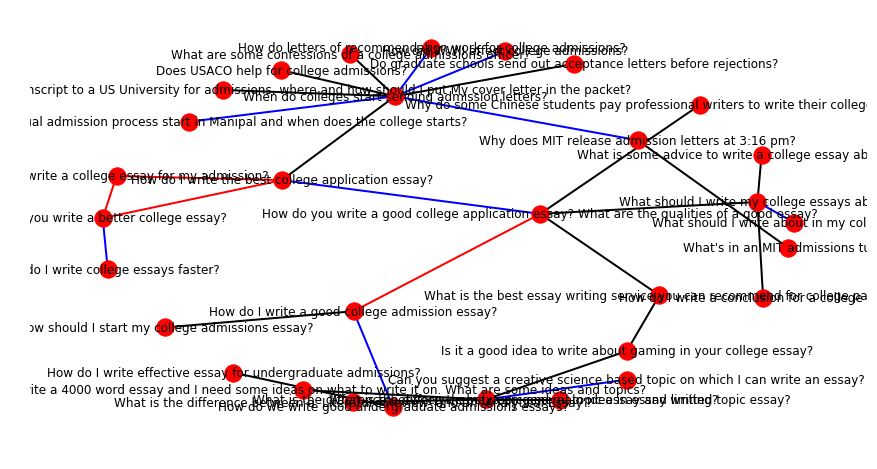

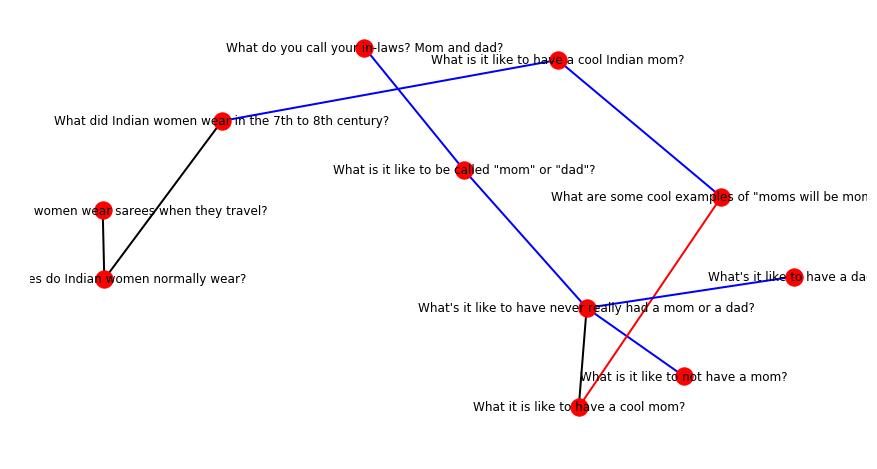

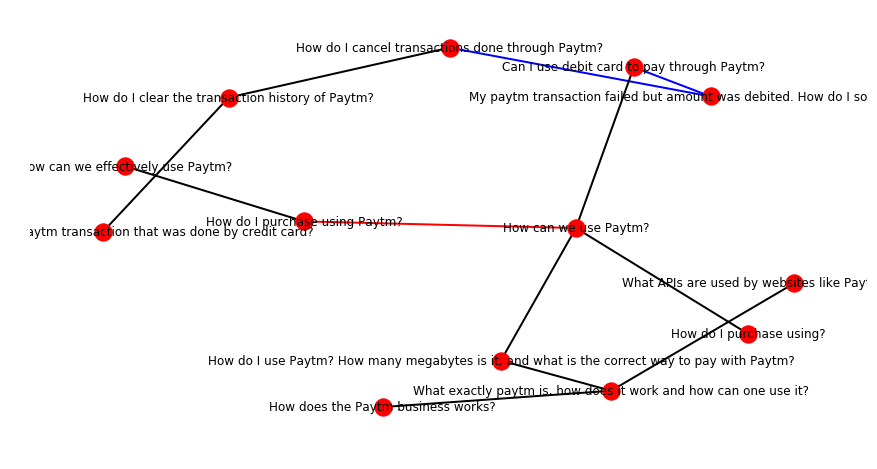

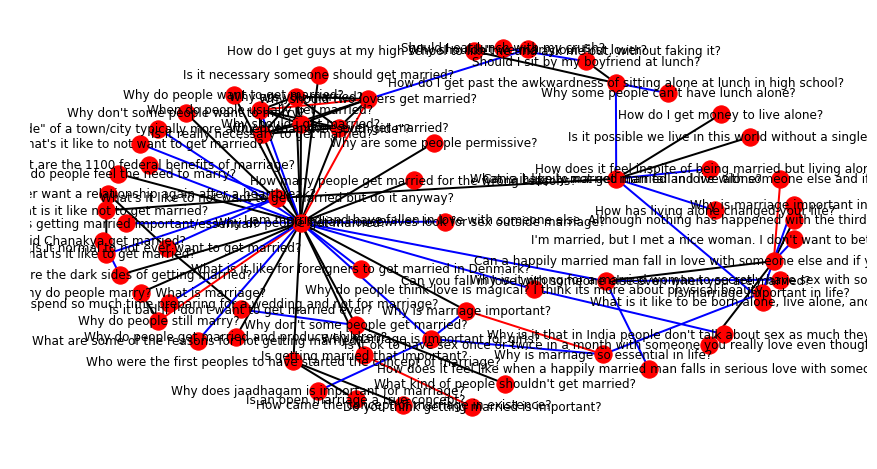

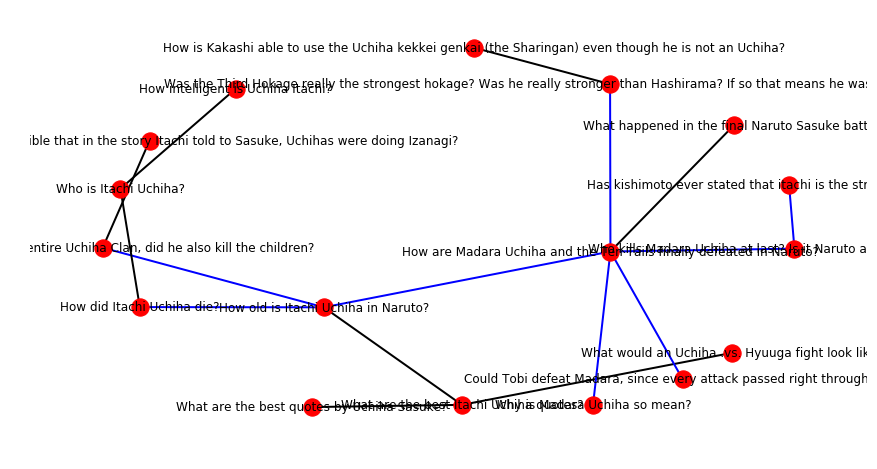

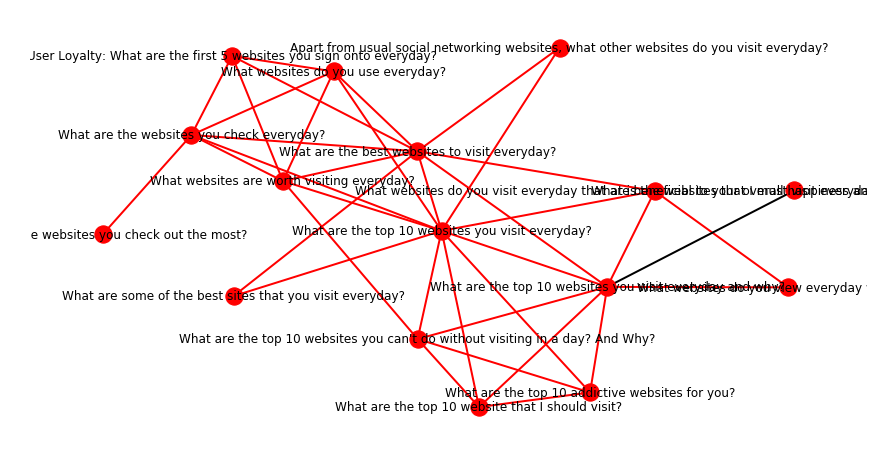

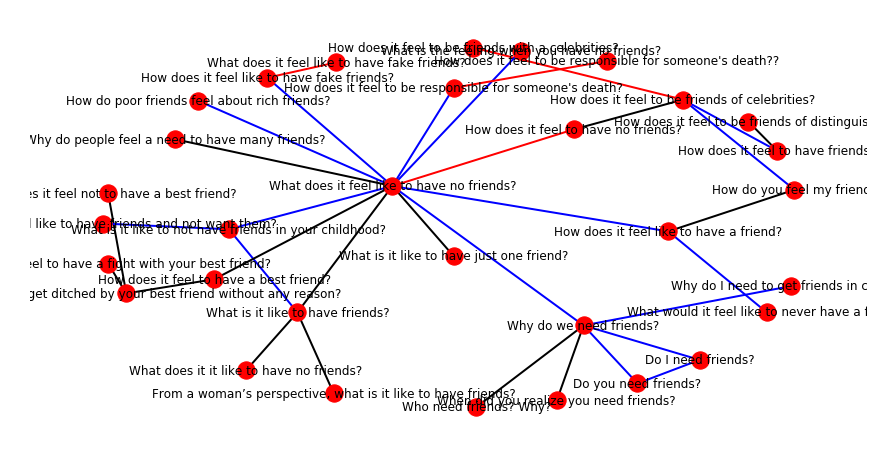

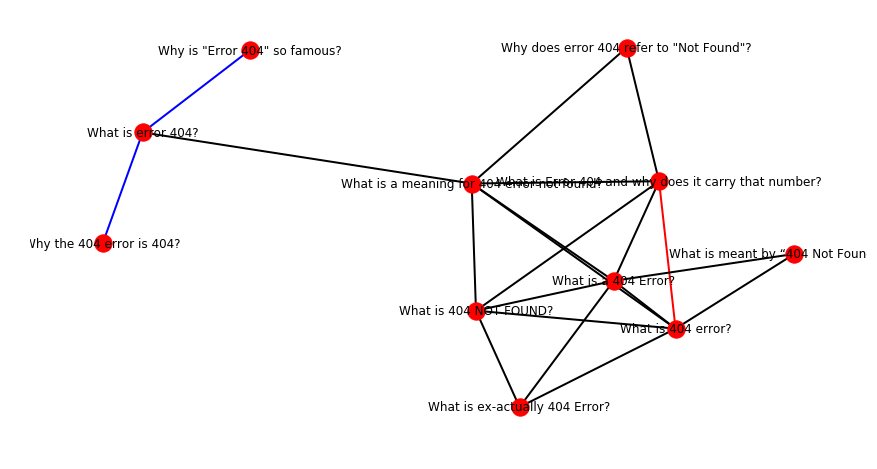

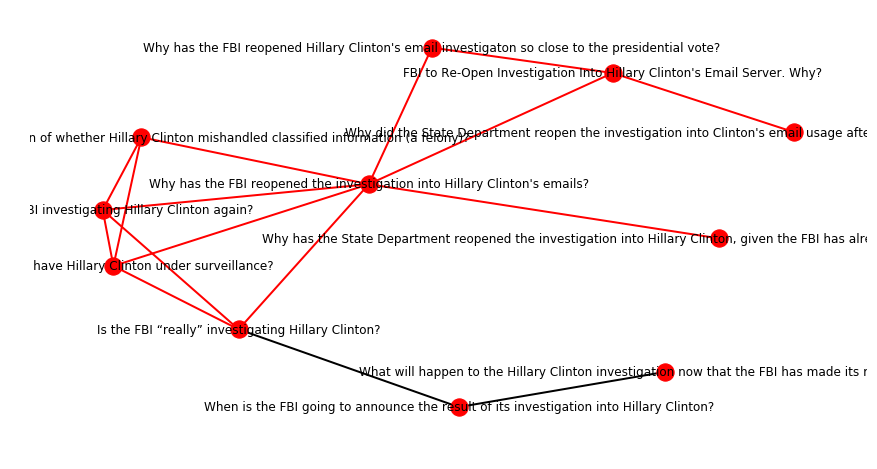

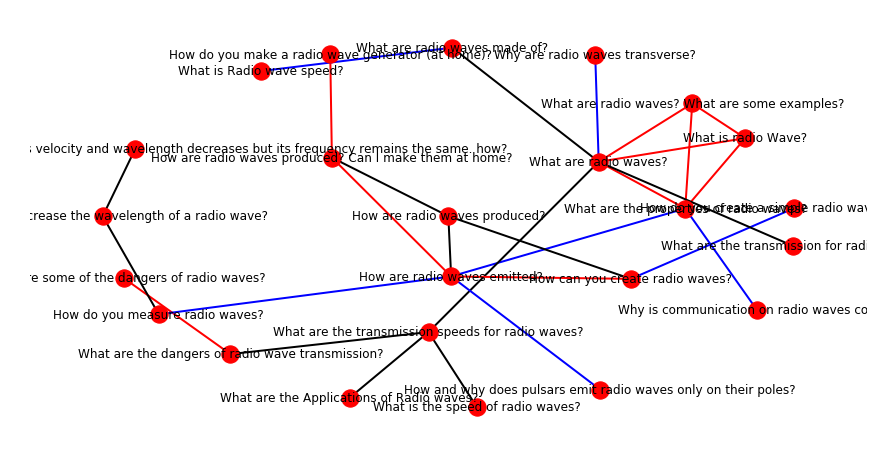

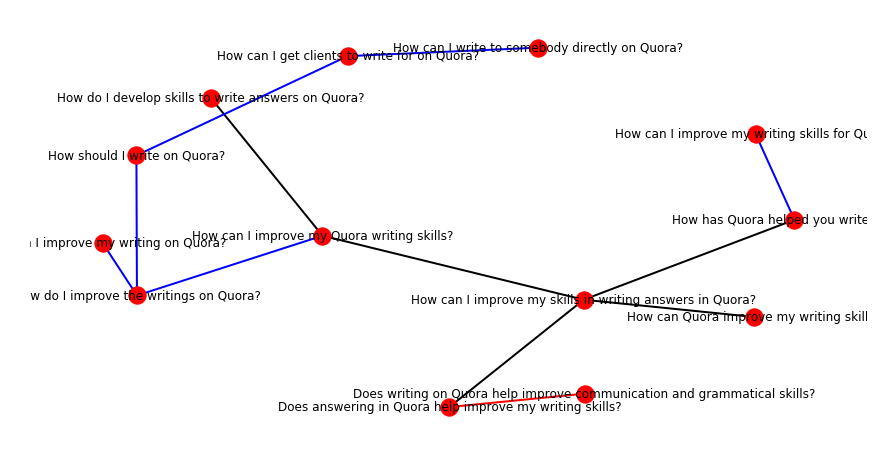

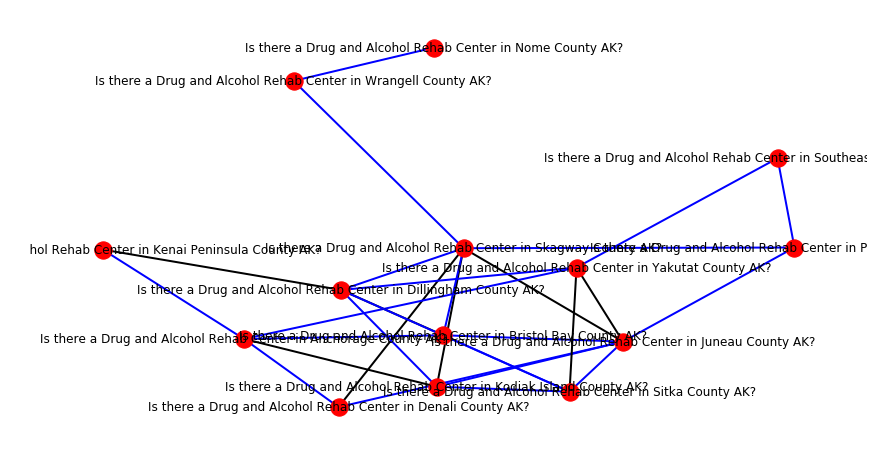

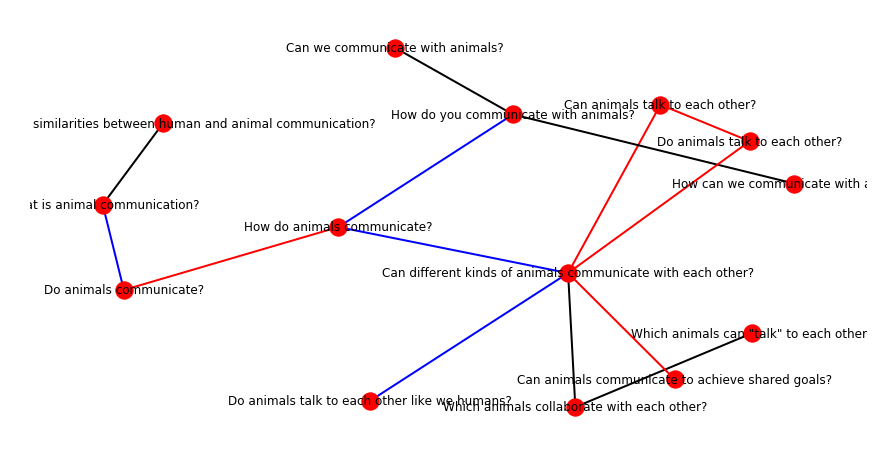

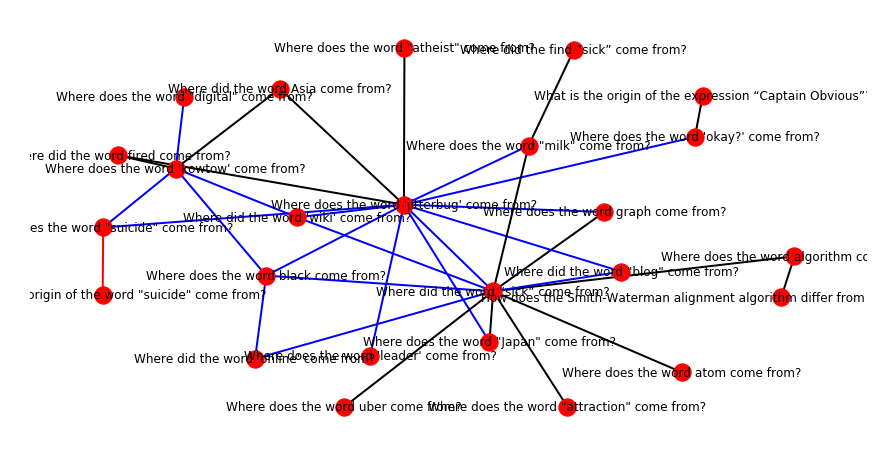

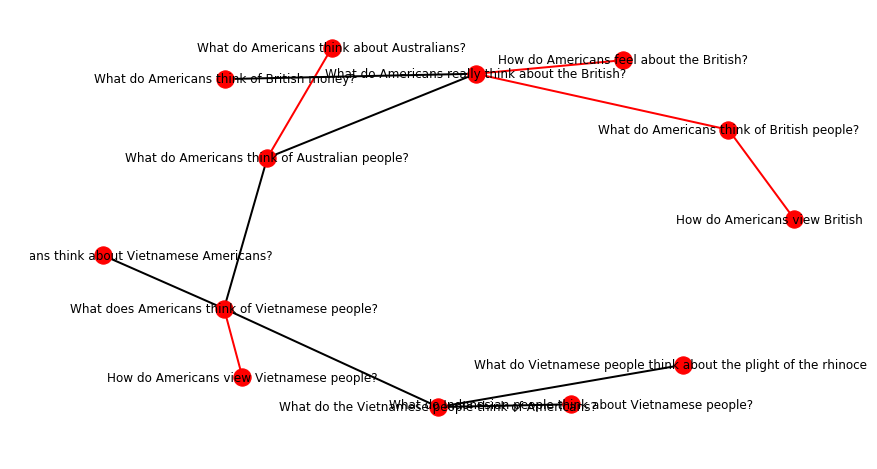

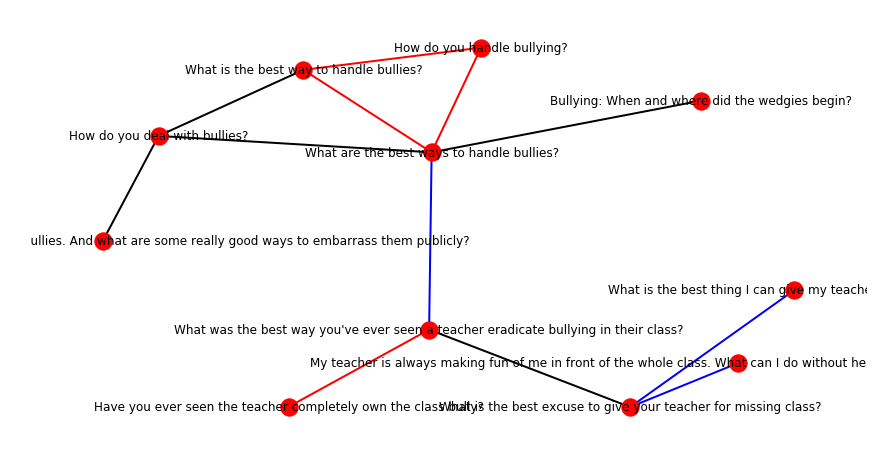

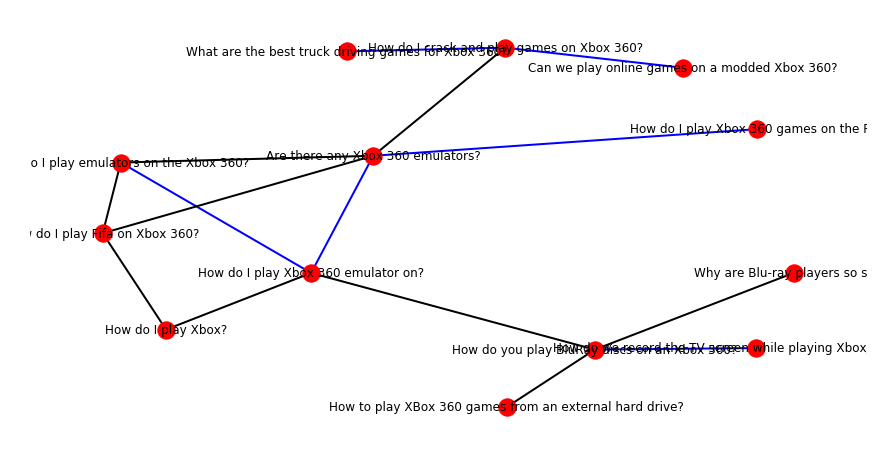

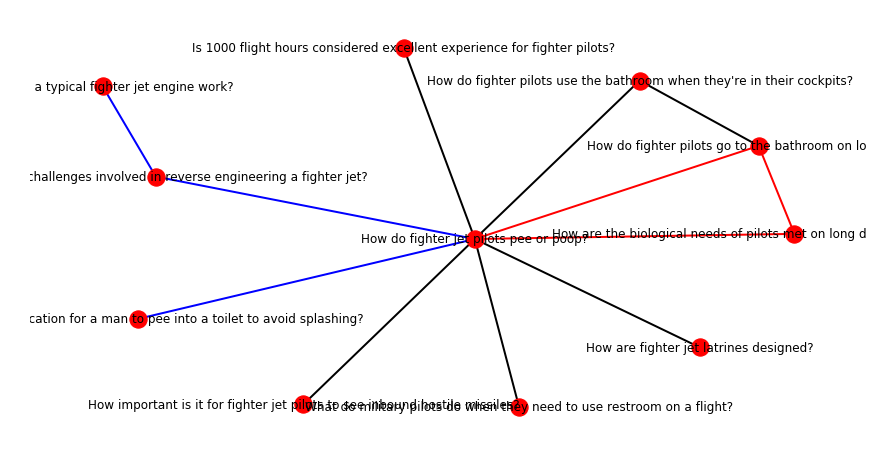

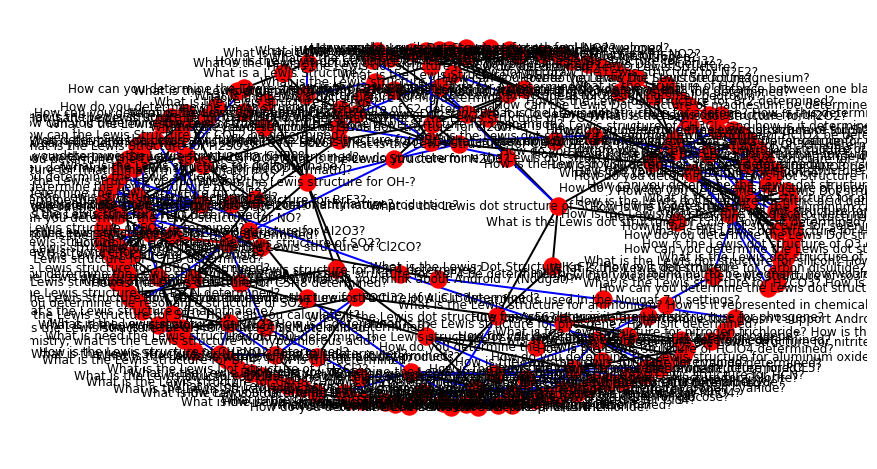

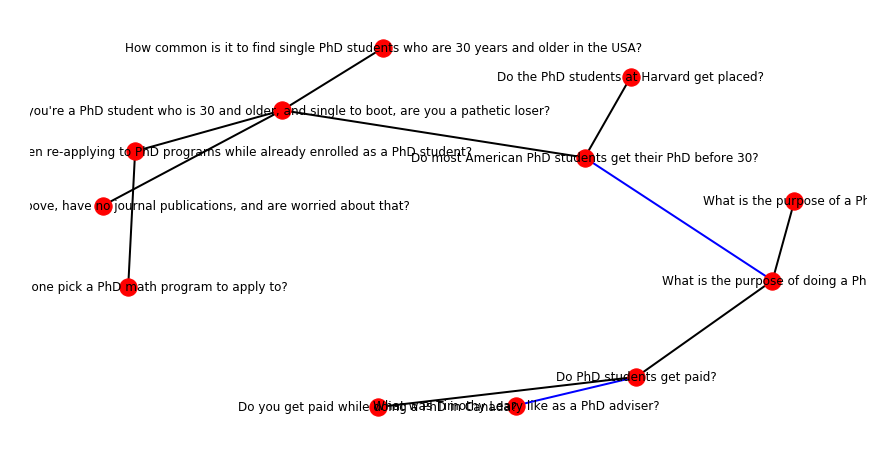

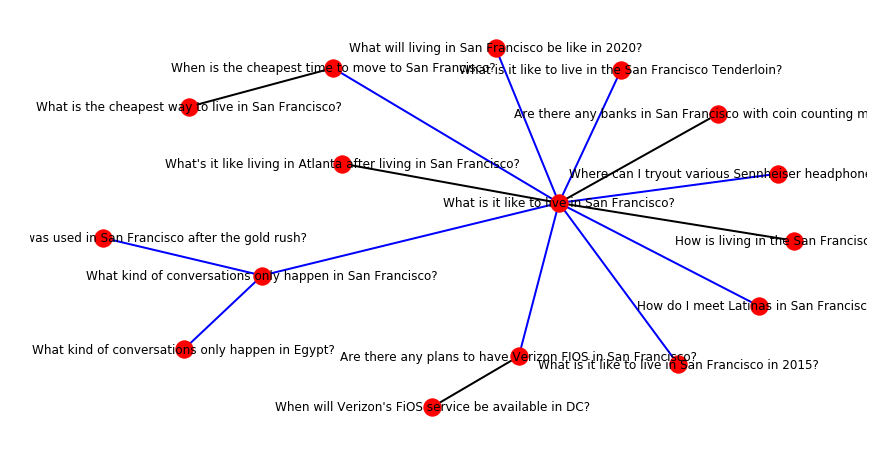

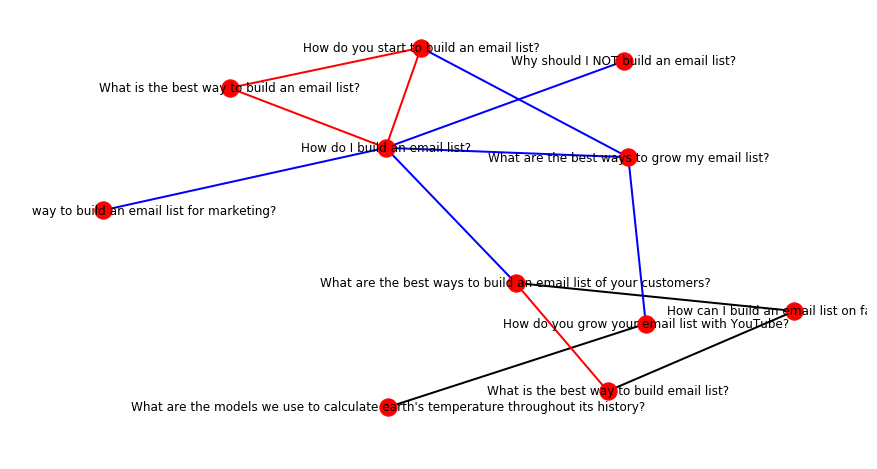

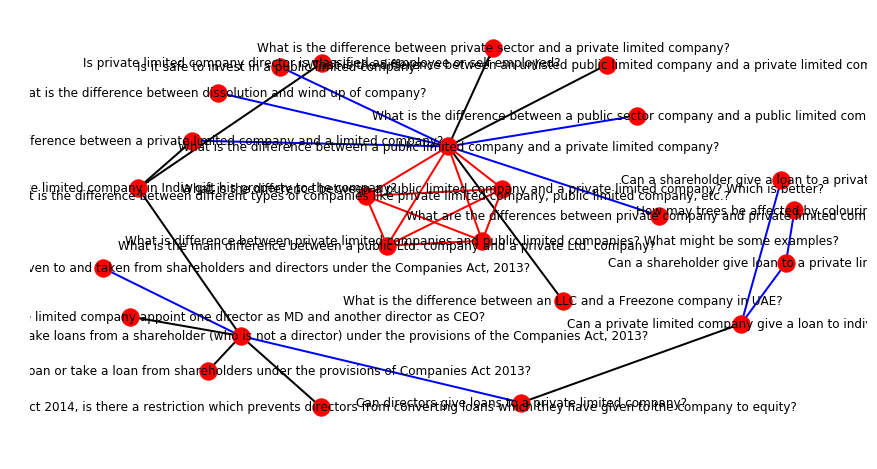

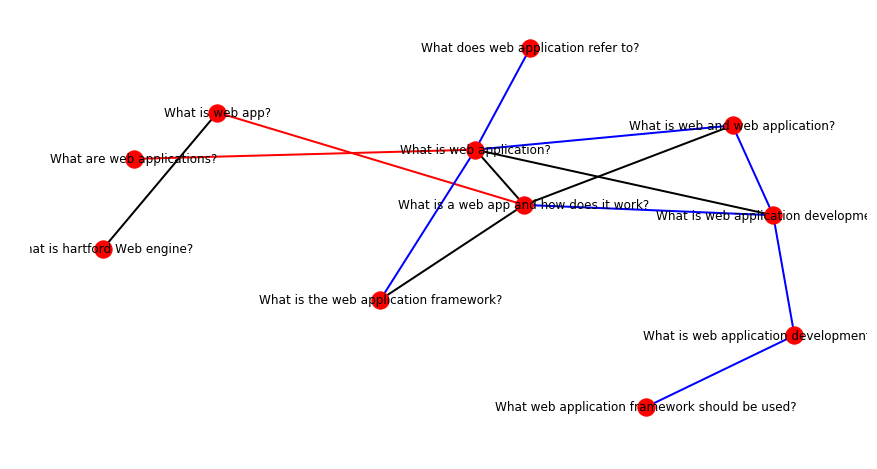

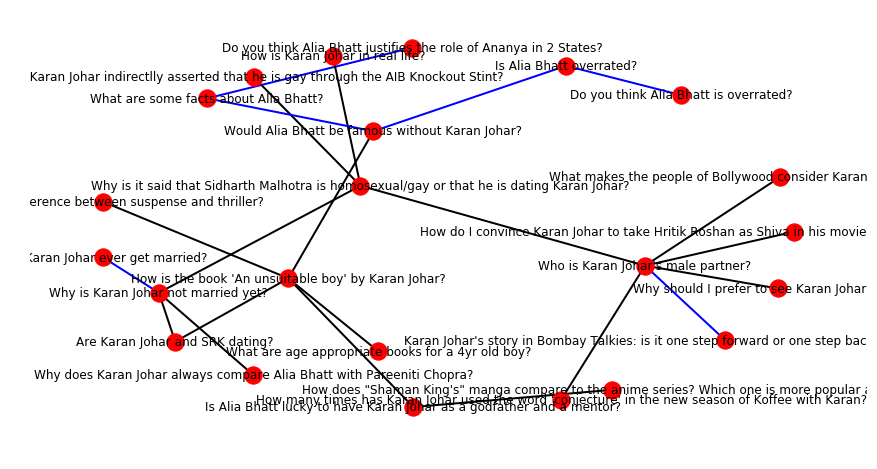

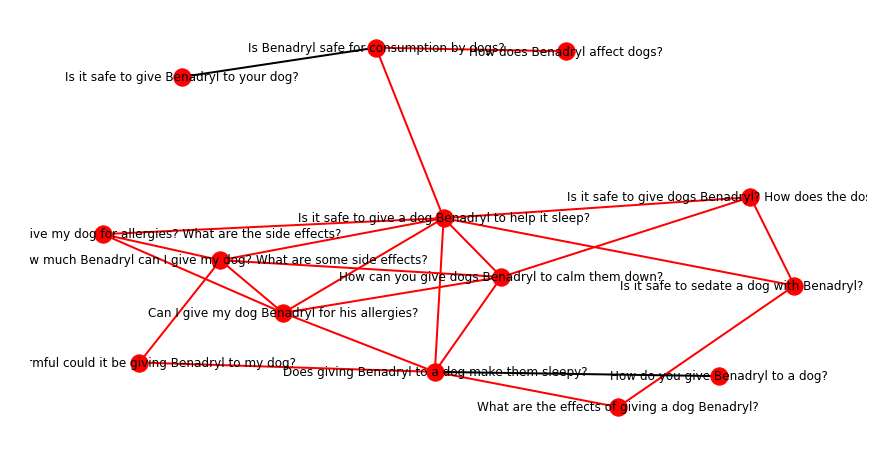

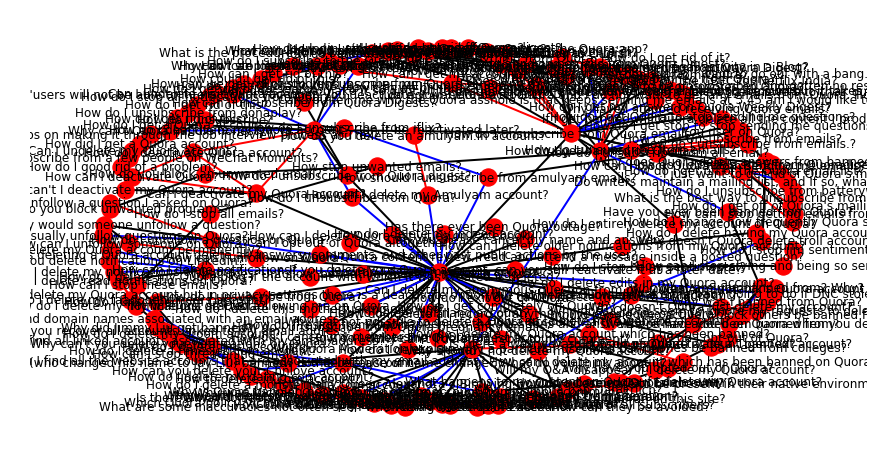

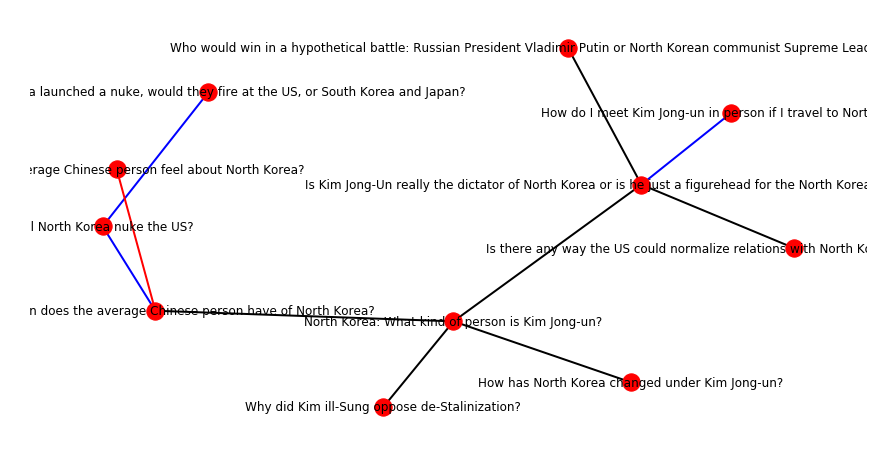

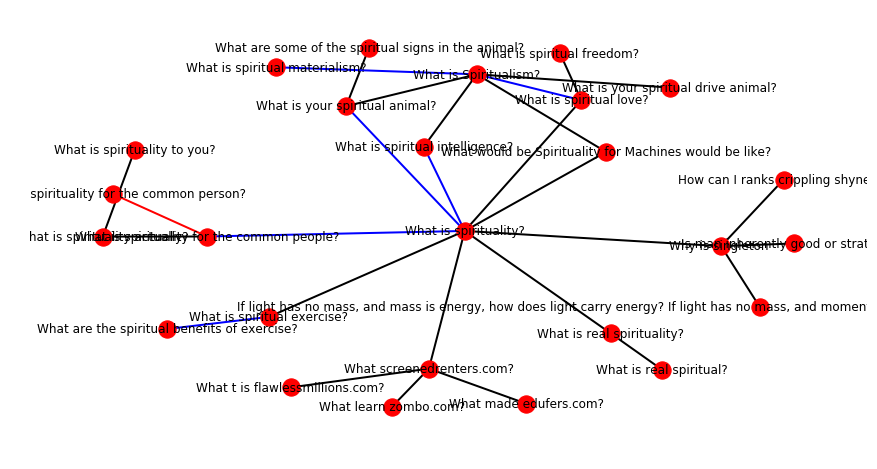

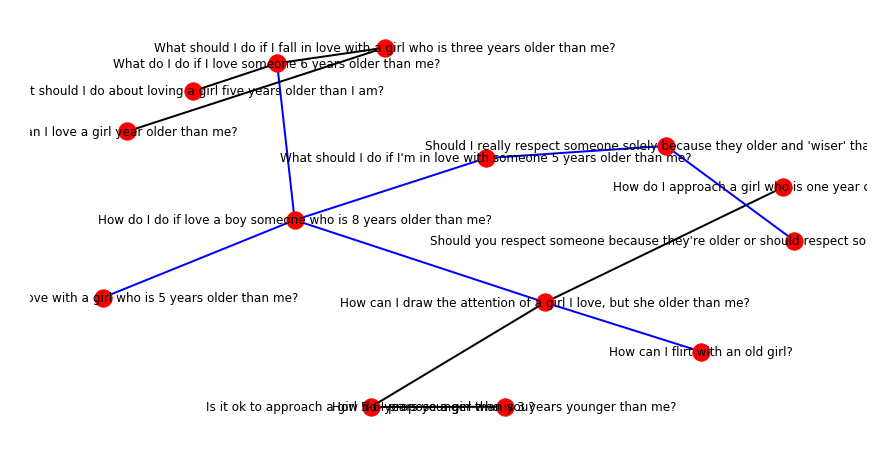

In [62]:
for i, row in temp_df[(temp_df.node_size > 10)].iloc[:40].iterrows():
    print(row['label'])
    plot_graph(row['label'], connected_components=connected_components)

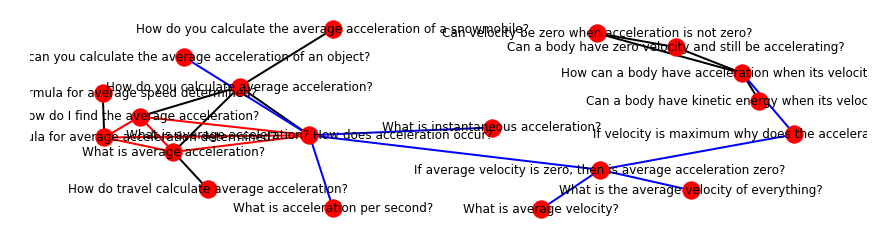

In [165]:
plot_graph('How is the formula for average speed determined?')

In [45]:
temp_df[temp_df.node_size > 100]

node_size  edge_size  \
343          228        339   
476          208        240   
1648         339        547   
1955         144        158   
2763      136001     211668   
5790         118        237   
6037         122        169   
6478         241        277   
6609         183        236   
7838         180        184   
8083         117        116   
8252         160        675   
9651         282        606   
10958        201        229   
11238        115        143   
11869        160        206   
12859        128        196   
13220        170        240   
14074        300        348   
14712        132        155   
17065        105        214   
17765        110        227   
19358        114        162   
19465        223        314   
19914        232        242   
20598        162        199   
21511        139        168   
21954        387        493   
23187        300        371   
23660        149        158   
...          ...        ...   
40517        133        140   
40688        359        490   
41259        126        186   
42408        108        115   
43012        136        258   
43489        232        377   
43882        110        214   
43995        122        139   
45149        110        117   
45695        109        387   
46710        178        260   
47047        173        178   
47366        104        133   
49157        163        202   
49192        497        579   
49516        147        421   
49586        158        361   
50115        141        177   
50510        289        362   
51361        134        274   
51756        144        147   
52978        149        181   
55658        124        140   
56053        237        273   
56240        121        195   
58235        136        235   
58445        105        133   
58805        116        163   
59015        140        307   
59210        101        123   

                                                                                                     label  \
343                                                               What is the Lewis Dot structure for Br3?   
476                                                                                     You user on Quora?   
1648                                                            Where can I learn trading stocks for free?   
1955                                What are the IDEs used to compile and execute C programs in Windows 8?   
2763                                                                What is peer to they peer replication?   
5790   If you want to correctly understand what occurs physically in nature is the last person to ask a...   
6037   How can someone in their mid-20's, still living with their parents, become a more independent ad...   
6478                                                             How can I get over an emotional hangover?   
6609                                       What is the best preparation method to pass Cisco 600-504 Exam?   
7838        If driving license is lost and duplicate license is not acquired, can we still drive in India?   
8083                                               How are the best products to cure acne pores and scars?   
8252                                      Where is the I find Jaw Crusher Metamorphic in Guinea-in Bissau?   
9651   I am a third year btech CSE student.Maybe I get an yearback. Is droping the course and joining c...   
10958                                                 What does the Spanish word "bañera" mean in english?   
11238                                                What is the relationship between voltage and current?   
11869            What are some tips on making it through the job interview process at Pacific Biosciences?   
12859                                                                  Which is the best, PS4 or Xbox One?   
13220                            What are large dog breeds that don't drool or at least very little? 50k

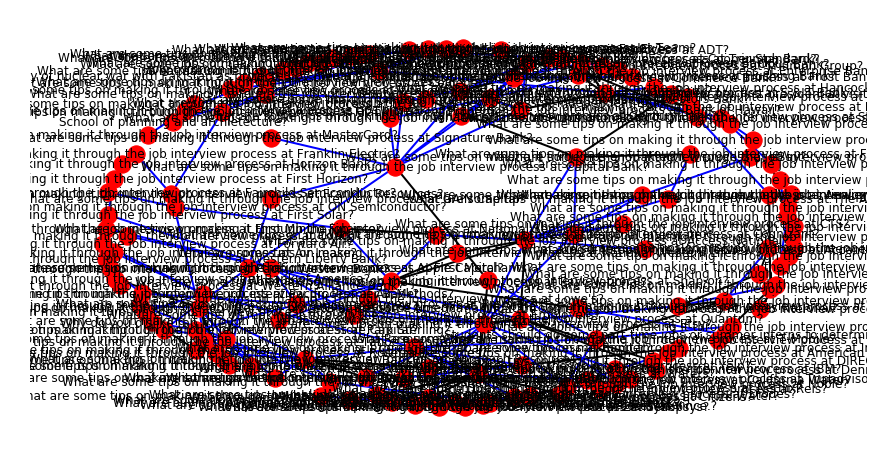

In [46]:
plot_graph('What are some tips on making it through the job interview process at Pacific Biosciences?')

In [49]:
largest_cc = connected_components['What is peer to they peer replication?']

In [166]:
largest_cc_after_removing_junk = []

def is_junk(q):
    junk_set = set([
        'What is?',
        'What is a?',
        'How can I improve my English?',
        'How do I improve my English?',
        'What are the best ways to lose weight?',
 "How can you look at someone's private Instagram account without following them?",
 'How can I lose weight quickly?',
 "What's the easiest way to make money online?",
 'How can I become fluent in English?',
 'What is the most effective way to lose weight?',
 'What are some things new employees should know going into their first day at AT&T?',
 'What is the purpose of life?',
 'What are the best ways to reduce and eliminate belly, abdominal, and thigh fat?',
 'Can you see who views your Instagram?',
 'How can you increase your height?',
 'How can I earn money online?',
 'How do l see who viewed my videos on Instagram?',
 'What are some of the best ways to learn programming?',
 'How can I improve my writing skills?',
 "How do I reset my Gmail password when I don't remember my recovery information?",
 'How can I improve my English grammar?',
 'Does God exist?',
 'What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes?',
 'How can I improve my English pronunciation?',
 'How do I lose weight?',
 'What is the cheapest, painless, easiest way to commit suicide?',
 'How can I improve on my English?',
 'Why do some people ask questions on Quora that could easily be answered by using a search engine?',
 'How can I hack Facebook?',
 'I forgot my Facebook password and email password. How can I log into Facebook?',
 'How can I Improve my English?',
 'What is the meaning of life?',
 'How can I improve my english?',
 'How can I improve my spoken English?',
 'How can I improve my English skills?',
 'How earn money online?',
 'How I make money online?',
 'What are the best was to lose weight?',
 'How do I earn money online?',
 'Is Donald Trump likely to win the 2016 election (late 2015 / early 2016)?',
 'How is the word used in a sentence?',
 'Are we heading towards World War III?',
 'How can I improve in English?',
 'How do I completely and utterly kill and remove all my emotions forever, never to exist again, without losing my mind or intelligence?',
 'How do I earn money in online?',
 'How can improve my English speaking?',
 'How could I improve my English?',
 'What is the easy way to earn money online?',
 'How do I earn more money from online?',
 "Instagram (product): How can I login to Instagram if I don't remember the password, and I dont know the email address that was used to set up the account?",
 'What are the easy ways to earn money online?',
 'How should I lose weight?',
 'What is the easiest way to earn money from online?',
 'How can I improve my English speaking skills?',
        "How do I read someone's WhatsApp messages without any access to their mobile phone?",
 'How would demonetizing 500 and 1000 rupee notes and introducing new 2000 rupee notes help curb black money and corruption?',
 'What penis size do women prefer?',
 'What are the best movies of all time?',
 'How could I gain weight in a healthy way?',
 'What is the best phone to buy below 15k?',
 'Why do people ask questions on Quora that can easily be answered by Google?',
 'How do i lose weight?',
 'How can I stop worrying about what other people think?',
 'Why do people ask Quora questions which can be answered easily by Google?',
 'Where can I get online PDF or EPUB versions of books?',
 'How do I quickly and efficiently learn a new language?',
 'Why do some people on QUORA ask questions that they can easily findout on Google?',
 'How do you get a girl to like you?',
 'Why do people ask questions on Quora when they can easily find the answer for it on Google?',
 'Why do people ask questions on Quora that are easily to find answers too on Google?',
 'How do people earn money from YouTube?',
 'How can I lose weight?',
 "What are the common first signs of pregnancy? How can I tell if I'm pregnant? What are the symptoms?",
 'How can I get rid of my acne?',
 "How do you know if you're in love?",
 'Why do people ask stupid questions on Quora that could be easily answered by Google?',
 "How do I gain access to a person's instagram photos, if their account is private?",
 'What might happen now that President-elect Donald Trump has won the election? What will be the impact?',
 'Why do so many people ask questions on Quora that can be found in a Google search?',
 'How can learn English?',
 'Why do people ask Quora questions instead of just searching google?',
 'Smartphones: What is the best phone to buy below 10k rupees?',
 'What are the easiest ways to earn money online?',
 'Why do people ask questions on Quora before checking on Google?',
 'How can I improve my communication skills in English?',
 'What is the purpose of your life?',
 'How can I improve my English Language?',
 'What is a good website for free books?',
 'What can I do to improve my English speaking?',
 'How do I improve my English speaking?',
 'How can I improve my English in all aspects?',
 'How I can improve my English communication?',
 "Who is Donald Trump's base? Why is he popular? Why are people voting for him? Why do people like and support him?",
 'What are the best programming languages to learn today?',
 'How do I learn English?',
 'Why do people use Quora to ask questions when Google or Wikipedia would be sufficient?',
 'What should I do to earn money online?',
 'Why do people ask such questions here on Quora which could be easily found on the internet?',
 'What are the 4 best ways to lose weight?',
 'How do I retrieve deleted Snapchat messages?',
 'Why do so may people ask questions on Quora that can easily be found by a simple Google searh?',
 'How do I get more followers on Instagram?',
 'How do I make money online?',
 'What should I do to improve my English ?'
    ])
    return q in junk_set or (len([word for word in q.split(' ') if word != '']) and not q.endswith('?'))

for (q1, q2, val) in largest_cc:
    if is_junk(q1) or is_junk(q2):
        continue
    largest_cc_after_removing_junk.append((q1, q2, val))

In [167]:
print(len(largest_cc))
print(len(largest_cc_after_removing_junk))

211668
182514


In [168]:
union_find_after_removing_junk = UnionFind()
for (q1, q2, val) in largest_cc_after_removing_junk:
    union_find_after_removing_junk.unite(q1, q2)

In [169]:
connected_components_after_removing_junk = defaultdict(list)
for (q1, q2, val) in largest_cc_after_removing_junk:
    connected_components_after_removing_junk[union_find_after_removing_junk.find(q1)].append((q1, q2, val))

In [170]:
cc_df = connected_component_stats(connected_components_after_removing_junk, union_find_after_removing_junk)

In [171]:
display(cc_df[(cc_df.node_size > 2) & (cc_df.train_edge_count > 0)])

node_size  edge_size  \
1            28         34   
17            7          7   
23            6          5   
25            3          2   
30           62         63   
32            8          7   
34            7          6   
36            4          3   
38            3          2   
42            6          7   
43            3          2   
46            5          4   
48            6          5   
50           92        128   
51            4          3   
52            4          4   
53            4          3   
64           18         26   
65            6          5   
68            3          2   
75           11         38   
81           18         17   
91            4          3   
95           13         13   
98           31         31   
100          53        225   
107           3          2   
110           5          4   
116           7         13   
118           5          4   
...         ...        ...   
1427          4          3   
1431         10         10   
1432          7          6   
1437         67         71   
1438          3          2   
1441          3          2   
1444          7          6   
1451         14         16   
1457          6          5   
1458          6          6   
1460          6          8   
1463          4          3   
1466          7          9   
1467          4          3   
1470          3          2   
1472        196        394   
1477         12         53   
1481         12         14   
1489         17         17   
1493          4          3   
1498          6          5   
1510          4          3   
1512         13         12   
1524          5          5   
1526         11         11   
1539          4          3   
1540         10          9   
1545         12         11   
1546          9         14   
1559          4          3   

                                                                                                    label  \
1                                     How does one-sided love feel? What are its effects in the long run?   
17                                                               Will China ever become a true democracy?   
23                                                    How do I track an ip address of users on chat site?   
25                                                                Do Hinata and Naruto ever get together?   
30                                           What are the characteristics and effects of atherosclerosis?   
32                                                       How do I upload video on YouTube and make money?   
34                Does cervical dilation hurt? What are ways to cope with people who feel pain during it?   
36                                                                                 What is crowdsourcing?   
38                                               What should I do to remove black dots from cell culture?   
42                                                        What is it you do that gives your life meaning?   
43                                       What is the history of debit card development and use in the US?   
46                                                                               How does supernova form?   
48                                              How are carbon dioxide levels of the atmosphere measured?   
50                                            What do people mean when they say 42 is the answer to life?   
51                                                                     Is "Go You" grammatically correct?   
52                                                Which is the word camera smartphone under 15k in India?   
53                                                 Why do writers use imagery? What is the purpose of it?   
64                                                                            How do I hypnotize someone?   
65    You are offered a choice, you can pick two, become more attractive, 

In [172]:
display(cc_df[(cc_df.node_size > 1000)])
index = cc_df[(cc_df.node_size > 1000)].index[0]

node_size  edge_size                        label  train_edge_count  \
686     104085     168161  Is Trump University a scam?             84392   

     mean_duplicate  
686        0.530418

In [173]:
from collections import Counter
largest_cc_after_removing_junk =pd.DataFrame(data=connected_components_after_removing_junk[cc_df.iloc[index]['label']], columns=['q1', 'q2', 'label'])
counter = Counter(largest_cc_after_removing_junk.q1.tolist() + largest_cc_after_removing_junk.q2.tolist())

In [174]:
[k for k, v in counter.most_common(50)]


['What do you think about ban on Rs. 500 and Rs. 1000 currency notes?',
 'How can I recover my Gmail password without a recovery phone number or email?',
 'How can I increase the traffic on my website?',
 'How will the ban of Rs 500 and Rs 1000 notes affect Indian economy?',
 'What do you think about banning 500 and 1000 rupee notes in India?',
 'What evidence exists that Martin Luther King, Jr. engaged in orgies with white prostitutes and other women?',
 'How can I find my passion?',
 "How can I hack someone's WhatsApp account if I just have his WhatsApp account number?",
 'What would be some pros and cons of Donald Trump becoming president?',
 'What is love?',
 'Self-Improvement: How can I motivate myself to work hard?',
 'Which are the best ways to lose weight?',
 'How did Donald Trump win the 2016 Presidential Election?',
 'How does banning 500 and 1000 rupee notes help to control black money?',
 'How can I earn money part time online?',
 'Can I earn money online?',
 'How can I ear